In [1]:
import pandas as pd
import numpy as np

import tensorflow
import fnmatch
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2
import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split

import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
seed(101)
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.listdir('../input/cancer/Data')

['validation', 'train']

In [3]:
# Create a new directory to store all available images
all_images_dir = 'all_images_dir'
os.mkdir(all_images_dir)

In [4]:
!ls

__notebook_source__.ipynb  all_images_dir


In [5]:
# create a list of all patient id's
img_list = os.listdir('../input/cancer/Data')

for img in img_list:
    
    path_0 = '../input/cancer/Data/validation/X'
    path_1 =  '../input/cancer/Data/validation/Y'



    # create a list of all files in folder 0
    file_list_0 = os.listdir(path_0)
    # create a list of list all file in folder 1
    file_list_1 = os.listdir(path_1)

    # move the 0 images to all_images_dir
    for fname in file_list_0:

        # source path to image
        src = os.path.join(path_0, fname)
        # destination path to image
        dst = os.path.join(all_images_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


    # move the 1 images to all_images_dir
    for fname in file_list_1:

        # source path to image
        src = os.path.join(path_1, fname)
        # destination path to image
        dst = os.path.join(all_images_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [6]:

len(os.listdir('all_images_dir'))

5022

In [7]:
image_list = os.listdir('all_images_dir')

df_data = pd.DataFrame(image_list, columns=['image_id'])

df_data.head()

,image_id
0,8916_idx5_x1051_y901_class0.png
1,8917_idx5_x901_y751_class1.png
2,8956_idx5_x1701_y751_class1.png
3,8913_idx5_x201_y451_class0.png
4,8913_idx5_x401_y601_class0.png


In [8]:
def extract_target(x):
    # split into a list
    a = x.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
    target = b[5]
    
    return target


# create a new column called 'target'
df_data['target'] = df_data['image_id'].apply(extract_target)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
df_data.head(10)

,image_id,target
0,8916_idx5_x1051_y901_class0.png,0
1,8917_idx5_x901_y751_class1.png,1
2,8956_idx5_x1701_y751_class1.png,1
3,8913_idx5_x201_y451_class0.png,0
4,8913_idx5_x401_y601_class0.png,0
5,8916_idx5_x401_y951_class1.png,1
6,8918_idx5_x801_y1951_class1.png,1
7,8914_idx5_x3451_y2901_class0.png,0
8,8955_idx5_x1251_y701_class1.png,1
9,8914_idx5_x1751_y1851_class0.png,0


In [9]:
df_data.shape

(5022, 2)

In [10]:
# What is the class distribution?
df_data['target'].value_counts()

1    2511
0    2511
Name: target, dtype: int64

In [11]:
IMAGE_SIZE = 50

In [12]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(4519, 2)
(503, 2)


In [13]:
df_train['target'].value_counts()

0    2260
1    2259
Name: target, dtype: int64

In [14]:
df_val['target'].value_counts()

1    252
0    251
Name: target, dtype: int64

In [15]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # X
    # Y

# val_dir
    # X
    # Y


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
X = os.path.join(train_dir, 'X')
os.mkdir(X)
Y = os.path.join(train_dir, 'Y')
os.mkdir(Y)


# create new folders inside val_dir
X = os.path.join(val_dir, 'X')
os.mkdir(X)
Y = os.path.join(val_dir, 'Y')
os.mkdir(Y)

In [16]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['Y', 'X']

In [17]:
# Set the id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [18]:
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    
    fname = image
    # get the label for a certain image
    target = df_data.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'X'
    if target == '1':
        label = 'Y'
    
    # source path to image
    src = os.path.join(all_images_dir, fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # move the image from the source to the destination
    shutil.move(src, dst)
    

# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df_data.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'X'
    if target == '1':
        label = 'Y'
    

    # source path to image
    src = os.path.join(all_images_dir, fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # move the image from the source to the destination
    shutil.move(src, dst)

In [19]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/X')))
print(len(os.listdir('base_dir/train_dir/Y')))

2260
2259


In [20]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/X')))
print(len(os.listdir('base_dir/val_dir/Y')))

251
252


In [21]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'


num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [22]:
datagen = ImageDataGenerator(rescale=1.0/255,
                            zoom_range = 2,
                            rotation_range = 20,
                            horizontal_flip = True,
                            vertical_flip = True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 4519 images belonging to 2 classes.
Found 503 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


In [23]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)        3

In [24]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [25]:
filepath = "cnn.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=100, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/20
100/100 [==============================] - 10s 26ms/step - loss: 0.6920 - accuracy: 0.4887 - val_loss: 0.6921 - val_accuracy: 0.6223
Epoch 2/20
100/100 [==============================] - 2s 21ms/step - loss: 0.6785 - accuracy: 0.5274 - val_loss: 0.6168 - val_accuracy: 0.6938
Epoch 3/20
100/100 [==============================] - 2s 21ms/step - loss: 0.6123 - accuracy: 0.7351 - val_loss: 0.5489 - val_accuracy: 0.7038
Epoch 4/20
100/100 [==============================] - 2s 21ms/step - loss: 0.5027 - accuracy: 0.7598 - val_loss: 0.4407 - val_accuracy: 0.8012
Epoch 5/20
100/100 [==============================] - 3s 26ms/step - loss: 0.4308 - accuracy: 0.8063 - val_loss: 0.4412 - val_accuracy: 0.8250
Epoch 6/20
100/100 [==============================] - 2s 24ms/step - loss: 0.4658 - accuracy: 0.7957 - val_loss: 0.4243 - val_accuracy: 0.8231
Epoch 7/20
100/100 [==============================] - 2s 21ms/step - loss: 0.4203 - accuracy: 0.8210 - val_loss: 0.4290 - val_accuracy: 0.817

In [26]:
model.save('cnn.h5') 

In [27]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

<Figure size 432x288 with 0 Axes>

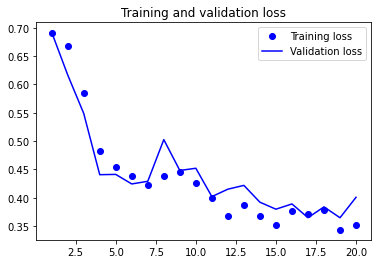

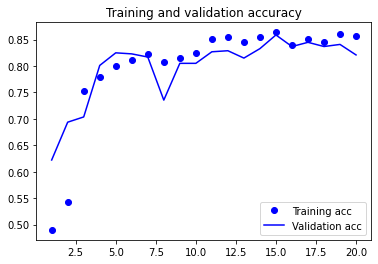

<Figure size 432x288 with 0 Axes>

In [28]:
# display the loss and accuracy curves

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [29]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

503/503 [==============================] - 2s 3ms/step


In [30]:
predictions.shape

(503, 2)

In [31]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'X': 0, 'Y': 1}

In [32]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['X', 'Y'])

df_preds.head()

,X,Y
0,0.978421,0.021579
1,0.967037,0.032963
2,0.867609,0.132391
3,0.007880,0.992120
4,0.563213,0.436787


In [33]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['Y']

In [34]:

roc_auc_score(y_true, y_pred)


0.9285239992411307

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [36]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [37]:
test_labels.shape


(503,)

In [38]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[188  63]
 [ 22 230]]


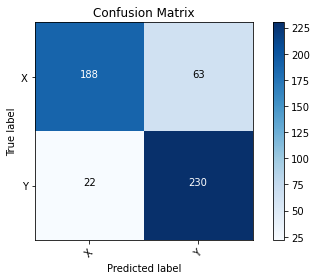

In [39]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['X', 'Y']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [40]:

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

           X       0.90      0.75      0.82       251
           Y       0.78      0.91      0.84       252

    accuracy                           0.83       503
   macro avg       0.84      0.83      0.83       503
weighted avg       0.84      0.83      0.83       503



In [41]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [42]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

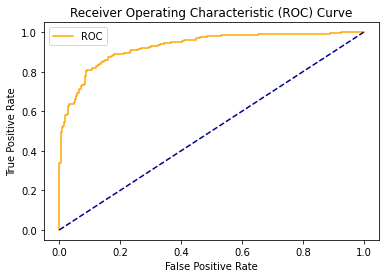

In [43]:
plot_roc_curve(fpr, tpr)